In [1]:
import scipy as sc
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl

In [2]:
# BACKGROUND - define useful functions

# gives X(z) as defined in (8) Wang and Mota (note - k vanishes when calculating X)

def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + alpha_tilde
    
    if alpha_tilde == 0:
        return 1
    else:
        return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + Omega_r * (1 + z)** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)

# gives E(z) = H(z) / H0

def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + alpha_tilde
    

    if alpha_tilde == 0.0:
        ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
    else:
        
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1)/(2 * alpha_tilde))
    
    return ans

# gives dE/dz

def dEdz(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    
    # Wang and Mota
    dEdz = ((3 * Omega_m * (1 + z) ** 2) + (4 * Omega_r * (1 + z) ** 3) + (2 * Omega_k * (1 + z)))/(2 * E(z , cosmo) * np.sqrt(X(z , cosmo)))
    
    return dEdz

# gives dE/dx, x = lna

def dEdx(z , cosmo):
    
    dEdx = -dEdz(z , cosmo) * (1 + z)
    
    return dEdx

In [3]:
# PERTURBATIONS - define useful functions

# ---- finding D ------

def coupled_D_eqn(y , a , cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    
    D , acubedEdDda = y
    z = 1/a - 1
    ydot = [ acubedEdDda/(a*a*a*E(z,cosmo)), 1.5*Omega_m*D/(E(z, cosmo)*a*E(z, cosmo)*a)]
    return ydot

In [4]:
# Define constants

cosmo = [0.4, 0.045 , 0 , 9.2e-5 , 0]                      #  Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde 
cosmoLCDM = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.81,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2], 
                               Omega_g=cosmo[3])
                   
# create coord times
p = 3
x = np.linspace(-5, 0, int(10**p))
a = np.exp(x)
z = 1/a - 1


In [5]:
# create boundary condition for D. Specs give, for g(a) = D/a, g(a) = 1 and g'(a) = 0 for sufficienly large redshift.
BCs = [a[0],1]


#find solution
soln = odeint(coupled_D_eqn, BCs, a, args=(cosmo,), mxstep=int(1e4))

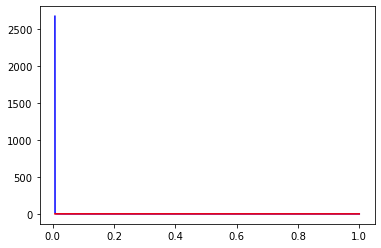

In [6]:
D = soln.T[0]
dDdx = soln.T[1]/(a*a*E(z,cosmo))

f = dDdx/D
plt.plot(a,f, color = "b")
plt.plot(a, ccl.growth_rate(cosmoLCDM,a), color = "r")

plt.show()